<a href="https://colab.research.google.com/github/Ro-shni/PDF-IMAGE-IDENTIFIER/blob/main/doodle_classifier_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
!pip3 install opencv-python
!pip3 install matplotlib
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 41.6 MB/s eta 0:00:00


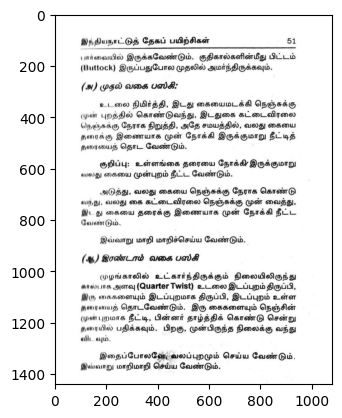

In [4]:
img = cv2.imread("/content/exc1.jpg")
plt.imshow(img)

In [ ]:
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray,(25,25),50)
plt.imshow(blurred,cmap='gray')

In [ ]:
_, binary = cv2.threshold(blurred,225,255,cv2.THRESH_BINARY_INV)
plt.imshow(binary,cmap='gray')

In [ ]:
countours,_ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
statistics.mean([cv2.contourArea(cnt) for cnt in countours])

In [ ]:
contour_image = img.copy()
drawn_contours = cv2.drawContours(contour_image, countours, -1, (0, 255, 0), 3)
plt.figure(figsize=(15,15))
plt.imshow(contour_image)

In [26]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import statistics

def load_pdf_as_images(pdf_path, zoom_x=2.0, zoom_y=2.0):
    """Load a PDF file and convert each page into an image with higher zoom (resolution)."""
    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)  # Load page
        mat = fitz.Matrix(zoom_x, zoom_y)  # Create a transformation matrix for zoom
        pix = page.get_pixmap(matrix=mat)  # Render page as an image with the zoom
        img = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
        if pix.n == 4:  # If the image has an alpha channel, remove it
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        images.append(img)
    doc.close()
    return images

def preprocess_image(img, kernel_size=(5, 5), sigma=10):
    """Apply Gaussian blur to the grayscale image to reduce noise and improve contour detection."""
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)
    return blurred

def threshold_and_find_contours(blurred_img):
    """Threshold the blurred image and find contours."""
    _, binary = cv2.threshold(blurred_img, 225, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours, binary

def classify_image(contours, img_shape, min_contour_area=1500, image_area_threshold=20000):
    """
    Classify the page based on the analysis of contours.
    Identify if the page contains images, text, or both.
    """
    page_area = img_shape[0] * img_shape[1]

    if not contours:
        return "Text"  # No contours found, assume text

    # Filter out small contours (small noise or text-like elements)
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_contour_area]

    if not filtered_contours:
        return "Text"  # No significant contours, assume text

    # Calculate the mean contour area of filtered contours
    mean_area = statistics.mean([cv2.contourArea(c) for c in filtered_contours])

    # Calculate total contour area to page area ratio
    total_contour_area = sum([cv2.contourArea(c) for c in filtered_contours])
    contour_area_ratio = total_contour_area / page_area

    # Check for the presence of small and large contours
    small_contours = [c for c in contours if cv2.contourArea(c) <= min_contour_area]
    large_contours = [c for c in contours if cv2.contourArea(c) > image_area_threshold]

    if large_contours and small_contours:
        return "Image+Text"  # Both significant image and text-like contours found

    # Classify as "Image" if we have larger contour areas
    if mean_area > image_area_threshold or contour_area_ratio > 0.5:
        return "Image"

    # Default to "Text" for pages with smaller contour areas
    return "Text"

def process_pdf_pages(pdf_path, zoom_x=2.0, zoom_y=2.0, min_contour_area=1500, image_area_threshold=20000):
    """Process each page of a PDF, classify each page as text, image, or both, and return the page numbers."""
    image_pages = []
    text_image_pages = []

    # Load the PDF and convert each page to an image
    images = load_pdf_as_images(pdf_path, zoom_x=zoom_x, zoom_y=zoom_y)

    for page_num, img in enumerate(images):
        # Convert to grayscale if necessary
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Preprocess (Gaussian Blur)
        blurred_img = preprocess_image(gray, kernel_size=(5, 5), sigma=10)

        # Apply thresholding and find contours
        contours, _ = threshold_and_find_contours(blurred_img)

        # Classify based on contour analysis
        classification = classify_image(contours, img.shape, min_contour_area=min_contour_area, image_area_threshold=image_area_threshold)

        # Collect the page number based on classification
        if classification == "Image":
            image_pages.append(page_num + 1)  # Human-readable page number
        elif classification == "Image+Text":
            text_image_pages.append(page_num + 1)

    return image_pages, text_image_pages

# Example usage:
pdf_path = "/content/doodle.pdf"  # Replace with the path to your PDF file
image_pages, text_image_pages = process_pdf_pages(pdf_path, zoom_x=2.0, zoom_y=2.0, min_contour_area=1500, image_area_threshold=20000)

# Output results
if image_pages:
    print(f"Pages with only images: {image_pages}")
else:
    print("No pages with only images found.")

if text_image_pages:
    print(f"Pages with images and text: {text_image_pages}")
else:
    print("No pages with images and text found.")


No pages with only images found.
Pages with images and text: [1, 19, 24, 29, 33, 39, 45, 50, 56, 63, 70, 76, 83, 86, 101, 106]
